In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [33]:
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [5]:
# build the model
# two conv layers:
# conv1 = nn.Conv2d(1,6,3,1)
# more detalis: shift + tab; 1-input color channel, 6-output channel (filters)
# 3-kernal size(a 3*3 filter), 1-stride

# process: conv1 INPUT -> 6 filters -> pooling -> conv2

# conv2 = nn.Conv2d(6,16,3,1)
# 6-filters in the last layer

In [6]:
conv1 = nn.Conv2d(1,6,3,1)
conv2 = nn.Conv2d(6,16,3,1)

In [7]:
# grab a single image from the dataset
for i, (X_train,y_train) in enumerate(train_data):break

In [8]:
#X_train.shape # -> 4D batch (batch of 1 image)
x = X_train.view(1,1,28,28) # -> add batch as another dimension

In [9]:
x = F.relu(conv1(x))

In [10]:
x.shape # 26: it means because of 0 padding, some border after scanning some info is lost!

torch.Size([1, 6, 26, 26])

In [11]:
# pass the data to a pooling layer
x = F.max_pool2d(x,2,2)#2,2 kernal size and stride
# https://pytorch.org/docs/master/generated/torch.nn.MaxPool2d.html for max_pool2d
x.shape

torch.Size([1, 6, 13, 13])

In [12]:
x = F.relu(conv2(x))

In [13]:
x.shape

torch.Size([1, 16, 11, 11])

In [14]:
x = F.max_pool2d(x,2,2) #11/2
x.shape

torch.Size([1, 16, 5, 5])

In [15]:
(((28-2)/2)-2)/2 #conv -2; pooling /2

5.5

In [16]:
x.view(-1,16*5*5).shape #keep the first dim and flatten the rest 

torch.Size([1, 400])

<div class="alert alert-info"><strong>Basic steps of CNNs</strong><br>

1. Extend the base Module class:
   
<tt><font color=black>class ConvolutionalNetwork(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Set up the convolutional layers with <a href='https://pytorch.org/docs/stable/nn.html#conv2d'><tt><strong>torch.nn.Conv2d()</strong></tt></a><br><br>The first layer has one input channel (the grayscale color channel). We'll assign 6 output channels for feature extraction. We'll set our kernel size to 3 to make a 3x3 filter, and set the step size to 1.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.conv1 = nn.Conv2d(1, 6, 3, 1)</font></tt><br>
The second layer will take our 6 input channels and deliver 16 output channels.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.conv2 = nn.Conv2d(6, 16, 3, 1)</font></tt><br><br>

3. Set up the fully connected layers with <a href='https://pytorch.org/docs/stable/nn.html#linear'><tt><strong>torch.nn.Linear()</strong></tt></a>.<br><br>The input size of (5x5x16) is determined by the effect of our kernels on the input image size. A 3x3 filter applied to a 28x28 image leaves a 1-pixel edge on all four sides. In one layer the size changes from 28x28 to 26x26. We could address this with zero-padding, but since an MNIST image is mostly black at the edges, we should be safe ignoring these pixels. We'll apply the kernel twice, and apply pooling layers twice, so our resulting output will be 
$\;(((28-2)/2)-2)/2 = 5.5\;$ which rounds down to 5 pixels per side.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc1 = nn.Linear(5\*5\*16, 120)</font></tt><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc2 = nn.Linear(120, 84)</font></tt><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc3 = nn.Linear(84, 10)</font></tt><br>
See below for a more detailed look at this step.<br><br>

4. Define the forward method.<br><br>Activations can be applied to the convolutions in one line using <a href='https://pytorch.org/docs/stable/nn.html#id27'><tt><strong>F.relu()</strong></tt></a> and pooling is done using <a href='https://pytorch.org/docs/stable/nn.html#maxpool2d'><tt><strong>F.max_pool2d()</strong></tt></a><br>
<tt><font color=black>def forward(self, X):<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.conv1(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.max_pool2d(X, 2, 2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.conv2(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.max_pool2d(X, 2, 2)<br>
</font></tt>Flatten the data for the fully connected layers:<br><tt><font color=black>
&nbsp;&nbsp;&nbsp;&nbsp;X = X.view(-1, 5\*5\*16)<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.fc1(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = self.fc2(X)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return F.log_softmax(X, dim=1)</font></tt>
</div>

In [21]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        # pooling layer is not in this __init__
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16,120) #120 is an arbitary layer of outputs
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10) # cls
    
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,16*5*5) #-1 we can vary the batch size
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)

In [22]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
for param in model.parameters():
    print(param.numel())
# the total is half of a FNN

54
6
864
16
48000
120
10080
84
840
10


In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [37]:
import time
start_time = time.time()

# VARIABLES (TRACKERS)
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# FOR LOOP EPOCHS
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    #TRAIN
    for b,(X_train,y_train) in enumerate(train_loader):
        b += 1
        
        y_pred = model(X_train) #NO FLATTEN (diff from FNN)
        loss = criterion(y_pred,y_train)
        
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum() #T 1 /F  0 sum
        trn_corr += batch_corr
        
        #update params
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600 ==0:
            print(f"EPOCH: {i} BATCH: {b} LOSS: {loss.item()}")
                          
    train_losses.append(loss)
    train_correct.append(trn_corr)
                  
    #TEST/VALIDATION
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
                  
            y_val = model(X_test)
                  
            predicted = torch.max(y_val.data,1)[1]
            
            tst_corr += (predicted == y_test).sum()
    
    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


current_time = time.time()
total = current_time - start_time
print(f"Training took {total/60} minutes")

EPOCH: 0 BATCH: 600 LOSS: 0.012995344586670399
EPOCH: 0 BATCH: 1200 LOSS: 0.007495527621358633
EPOCH: 0 BATCH: 1800 LOSS: 0.04154849797487259
EPOCH: 0 BATCH: 2400 LOSS: 0.00018332479521632195
EPOCH: 0 BATCH: 3000 LOSS: 0.00029973610071465373
EPOCH: 0 BATCH: 3600 LOSS: 0.0010472791036590934
EPOCH: 0 BATCH: 4200 LOSS: 0.0008818054338917136
EPOCH: 0 BATCH: 4800 LOSS: 0.00019562311354093254
EPOCH: 0 BATCH: 5400 LOSS: 0.0028294497169554234
EPOCH: 0 BATCH: 6000 LOSS: 0.0010296449763700366
EPOCH: 1 BATCH: 600 LOSS: 0.27665385603904724
EPOCH: 1 BATCH: 1200 LOSS: 0.004143804777413607
EPOCH: 1 BATCH: 1800 LOSS: 1.7773623767425306e-05
EPOCH: 1 BATCH: 2400 LOSS: 0.000122258483315818
EPOCH: 1 BATCH: 3000 LOSS: 0.0009686211124062538
EPOCH: 1 BATCH: 3600 LOSS: 1.0108776223205496e-05
EPOCH: 1 BATCH: 4200 LOSS: 0.0004972551832906902
EPOCH: 1 BATCH: 4800 LOSS: 0.008983483538031578
EPOCH: 1 BATCH: 5400 LOSS: 0.001931269420310855
EPOCH: 1 BATCH: 6000 LOSS: 0.0007894266163930297
EPOCH: 2 BATCH: 600 LOSS: 2

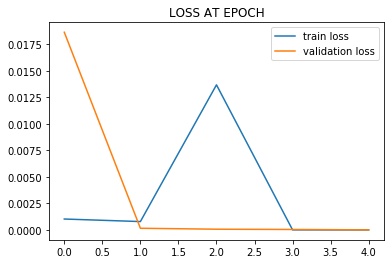

In [40]:
# plot the losses
plt.plot(train_losses,label = "train loss")
plt.plot(test_losses,label = "validation loss")
plt.title("LOSS AT EPOCH")
plt.legend()

..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


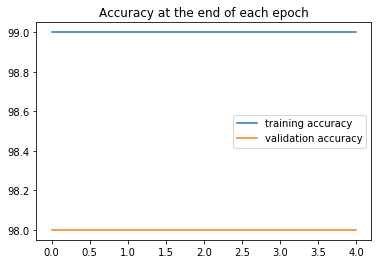

In [41]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [42]:
# evaluation
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [43]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9854/10000 =  98.540%


## Display the confusion matrix

In [44]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 975    1    1    0    1    2    4    0    7    1]
 [   0 1129    2    1    1    0    2    6    1    3]
 [   1    1 1026    4    1    1    3   14    2    0]
 [   0    0    0  991    0    5    0    1    1    0]
 [   0    0    0    0  964    0    2    0    3    6]
 [   0    0    0    9    0  880    1    0    2    5]
 [   2    3    0    0    6    1  945    0    0    0]
 [   2    0    2    1    0    1    0 1002    1    3]
 [   0    1    1    4    0    1    1    1  953    2]
 [   0    0    0    0    9    1    0    4    4  989]]


In [47]:
# run a new image (real testing)
test_data[2019][0].reshape(28,28) #no label

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

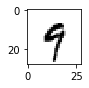

In [48]:
x = 2019
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg");

In [49]:
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[2019][0].view(1,1,28,28))

In [50]:
new_prediction

tensor([[-2.1287e+01, -2.4614e+01, -2.3708e+01, -2.1402e+01, -1.2825e+01,
         -1.9816e+01, -2.4991e+01, -1.4122e+01, -1.7844e+01, -3.4571e-06]])

In [52]:
new_prediction.argmax() #predicted class

tensor(9)

## Examine the misses
We can track the index positions of "missed" predictions, and extract the corresponding image and label. We'll do this in batches to save screen space.

In [53]:
# error analysis
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

146

In [54]:
# Display the first 10 index positions
misses[:10]

array([  18,  247,  447,  449,  495,  542,  551,  582,  619,  684],
      dtype=int64)

In [56]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Now that everything is set up, run and re-run the cell below to view all of the missed predictions.<br>
Use <kbd>Ctrl+Enter</kbd> to remain on the cell between runs. You'll see a <tt>StopIteration</tt> once all the misses have been seen.

Index: [  18  247  447  449  495  542  551  582  619  684  691  938]
Label: [   3    4    4    3    8    8    7    8    1    7    8    3]
Guess: [   8    2    9    5    0    5    9    2    8    3    4    5]


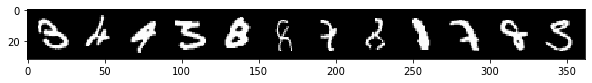

In [57]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));